In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

In [2]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


# Creating Target Variable: adopted_user

In [3]:
engage = pd.read_csv('takehome_user_engagement.csv')
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'])
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
# Group by user_id and count unique days visited within 7-day intervals
count_unique_users = engage.groupby([pd.Grouper(key='time_stamp', freq='W'), 'user_id']).size().reset_index(name='visits')

# Filter for users with at least 3 unique days visited
filtered_users = count_unique_users[count_unique_users['visits'] >= 3]

# Get the unique user_id values
unique_users = filtered_users['user_id'].unique()

# Display the result
print(unique_users)

[ 1693   728 11764 ...  9870 10746  8460]


In [5]:
# Set 'adopted_user' column to 0
users['adopted_user'] = 0

# If the user_id is in the unique_users, set 'adopted_user' to 1
users.loc[users['object_id'].isin(unique_users), 'adopted_user'] = 1

In [6]:
users['adopted_user'].value_counts()

0    10555
1     1445
Name: adopted_user, dtype: int64

# Exploring Features

In [98]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


## 1. `creation_source`

In [101]:
users['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [113]:
pd.crosstab(index=users['creation_source'], columns=users['adopted_user'], normalize='index')

adopted_user,0,1
creation_source,,
GUEST_INVITE,0.849283,0.150717
ORG_INVITE,0.884579,0.115421
PERSONAL_PROJECTS,0.930365,0.069635
SIGNUP,0.868232,0.131768
SIGNUP_GOOGLE_AUTH,0.851264,0.148736


## 2. `last_session_creation_time`

In [231]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [7]:
# Get list of users with NaN for this column
nan_last_login_users = list(users[users['last_session_creation_time'].isna()]['object_id'])

# Check for these user id's in user enagagment df
engage.loc[engage['user_id'].isin(nan_last_login_users)]

# Since those users have not been active since account creation, we will fill the NaN's with their creation time
users['last_session_creation_time'].fillna(users['creation_time'], inplace=True)

## 3. `opted_in_to_mailing_list`

In [8]:
users['opted_in_to_mailing_list'].value_counts()

0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

In [9]:
pd.crosstab(index=users['opted_in_to_mailing_list'], columns=users['adopted_user'], normalize='index')

adopted_user,0,1
opted_in_to_mailing_list,,
0,0.881523,0.118477
1,0.873747,0.126253


## 4. `enabled_for_marketing_drip`

In [10]:
users['enabled_for_marketing_drip'].value_counts()

0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64

In [11]:
pd.crosstab(index=users['enabled_for_marketing_drip'], columns=users['adopted_user'], normalize='index')

adopted_user,0,1
enabled_for_marketing_drip,,
0,0.880388,0.119612
1,0.875000,0.125000


## 5. `org_id`

In [12]:
org_counts = users['org_id'].value_counts().to_frame('counts')
uncommon_orgs = list(org_counts.query('counts < 20').index)
common_orgs = list(org_counts.query('counts >= 20').index)

In [13]:
users['org_type'] = 'uncommon'
users.loc[users['org_id'].isin(common_orgs), 'org_type'] = 'common'

In [14]:
users['org_type'].value_counts()

common      9379
uncommon    2621
Name: org_type, dtype: int64

In [15]:
pd.crosstab(index=users['org_type'], columns=users['adopted_user'], normalize='index')

adopted_user,0,1
org_type,,
common,0.887835,0.112165
uncommon,0.850057,0.149943


## 6. `creation_time`

In [16]:
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [17]:
users['month_created'] = users['creation_time'].dt.month
users['month_created'].value_counts()

5     1455
3     1177
4     1169
1     1029
11     936
2      934
12     930
10     924
9      901
7      852
8      852
6      841
Name: month_created, dtype: int64

In [18]:
pd.crosstab(index=users['month_created'], columns=users['adopted_user'], normalize='index')

adopted_user,0,1
month_created,,
1,0.872692,0.127308
2,0.874732,0.125268
3,0.892948,0.107052
4,0.923867,0.076133
5,0.953265,0.046735
6,0.837099,0.162901
7,0.869718,0.130282
8,0.846244,0.153756
9,0.855716,0.144284


## 7. `invited_by_user_id`

In [19]:
users['invited_by_user_id'].fillna(0, inplace=True)
users.loc[users['invited_by_user_id'] > 0, 'invited_by_user_id'] = 1

In [20]:
users['invited_by_user_id'].value_counts()

1.0    6417
0.0    5583
Name: invited_by_user_id, dtype: int64

In [21]:
pd.crosstab(index=users['invited_by_user_id'], columns=users['adopted_user'], normalize='index')

adopted_user,0,1
invited_by_user_id,,
0.0,0.887516,0.112484
1.0,0.872682,0.127318


In [22]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,org_type,month_created
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810.0,1,0,11,1.0,0,common,4
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504.0,0,0,1,1.0,1,common,11
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892.0,0,0,94,1.0,0,common,3
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168.0,0,0,1,1.0,0,common,5
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660.0,0,0,193,1.0,0,uncommon,1


# Feature Selection and Modeling

In [245]:
users.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted_user', 'org_type', 'month_created'],
      dtype='object')

In [112]:
features = ['creation_source', 'opted_in_to_mailing_list','org_type','month_created']

X = users[features]
X = pd.get_dummies(X, drop_first=True)

y = users['adopted_user']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

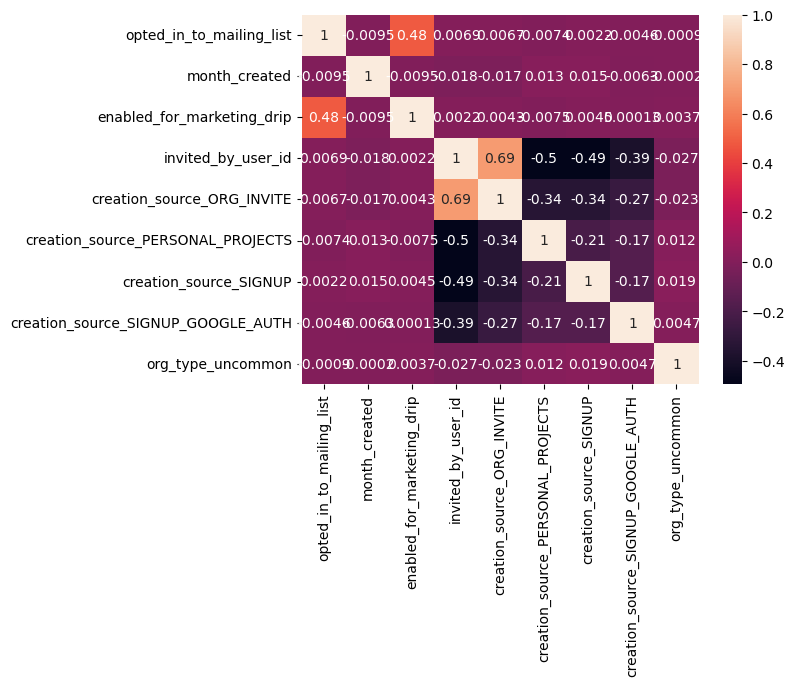

In [102]:
sns.heatmap(X.corr(), annot=True)
plt.show()

* `enabled_for_marketing_drip` and `opted_in_to_mailing_list` are fairly coorelated, so we may not need to include both in the model.
* `invited_by_user_id` is correlated with `creation` source, specifically the ORG_INVITE group


## Logistic Regression

In [95]:
lr = LogisticRegression(random_state=42, C=1, class_weight='balanced', penalty='l2')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.92      0.51      0.65      2111
           1       0.16      0.66      0.25       289

    accuracy                           0.53      2400
   macro avg       0.54      0.58      0.45      2400
weighted avg       0.82      0.53      0.61      2400



## Random Forest

In [96]:
rf = RandomForestClassifier(class_weight="balanced",  
                            max_features="sqrt",  
                            n_estimators=100,  
                            min_samples_split=5,  
                            min_samples_leaf=2,  
                            max_depth=10,  
                            min_weight_fraction_leaf=0.1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.56      0.70      2111
           1       0.16      0.59      0.25       289

    accuracy                           0.57      2400
   macro avg       0.53      0.58      0.47      2400
weighted avg       0.82      0.57      0.64      2400



# LightGBM

In [113]:
lgb = LGBMClassifier(class_weight='balanced',  # Adjust class weights
                    num_leaves=20,  # Set the maximum number of leaves in a tree
                    max_depth=5,  # Limit the maximum depth of trees
                    learning_rate=0.001,  # Set the learning rate
                    n_estimators=100,  # Set the number of boosting iterations
                    min_child_samples=10,  # Set a minimum number of samples for each leaf
                    colsample_bytree=0.8)

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.43      0.59      2111
           1       0.16      0.77      0.26       289

    accuracy                           0.47      2400
   macro avg       0.54      0.60      0.43      2400
weighted avg       0.84      0.47      0.55      2400



In [109]:
print('Cross Validated Accuracy: ',cross_val_score(lgb, X_train, y_train, cv=5).mean())
print('Cross Validated Recall: ',cross_val_score(lgb, X_train, y_train, cv=5, scoring='recall').mean())
print('Cross Validated Precision: ',cross_val_score(lgb, X_train, y_train, cv=5, scoring='precision').mean())
print('Cross Validated F1: ',cross_val_score(lgb, X_train, y_train, cv=5, scoring='f1').mean())



Cross Validated Accuracy:  0.49468750000000006
Cross Validated Recall:  0.6937154799223764
Cross Validated Precision:  0.151443515156301
Cross Validated F1:  0.2485092985205271


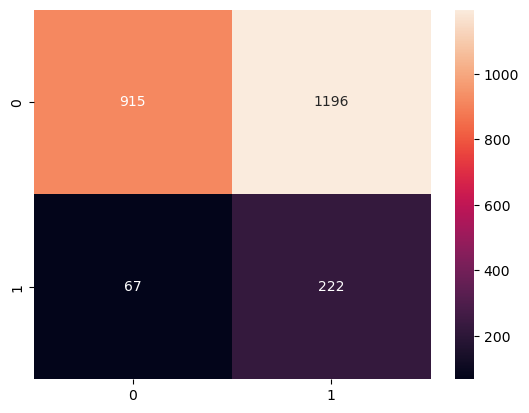

In [104]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='.4g')
plt.show()

# Feature Importances

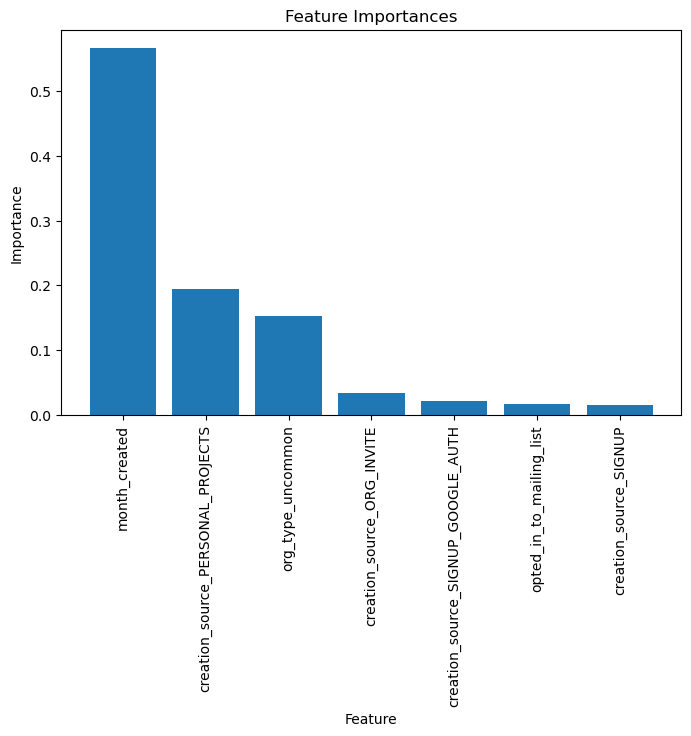

In [105]:
# Get feature importances from the trained model
importances = rf.feature_importances_

# Get the indices of features sorted by importance
indices = np.argsort(importances)[::-1]

# Get the column names from X_train
feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()



* `month_created`: From the EDA we can see that users that created their accounts betwee June and November had a higher rate of adoption than the rest of the year. June and October had the highest with approximately 16% of users being an adopted user

* `creation_source_PERSONAL_PROJECTS`: Only 7% of users who created their account for personal projects end up becoming an adopted user. 

* `org_type_uncommon`: 15% of users from the uncommon org group are adopted users, whereas only 11% from the common group are.

# Results

* Between the 3 models used, LightGB was the best model. The results were validated using cross-validation.

* Of the 289 adopted users in the test set, the model is correctly identifying 77% of them (recall).

* Of the 2111 non-adopted users in the test test, 43% are correctly identified.

* The model predicted that 1418 users would be adopted users. Only 16% of those were correct (precision)

* The overall accuracy is 47%.

* Overall, the model is able to perform adequately well at correctly identifying adopted users, however there is a high number of false positives.